### Pre-note: This notebook re-run multiple times with different batch sizes for each network

In [1]:
import pyspark
pyspark.__version__

'2.4.0'

In [2]:
%matplotlib inline

import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession

from pyspark import SparkConf
from pyspark.ml.feature import StandardScaler, VectorAssembler, OneHotEncoder, MinMaxScaler, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from distkeras.transformers import OneHotTransformer, MinMaxTransformer, LabelIndexTransformer,\
                                ReshapeTransformer, DenseTransformer
from distkeras.evaluators import AccuracyEvaluator
from distkeras.predictors import ModelPredictor
from distkeras.trainers import DOWNPOUR, ADAG, AEASGD, SingleTrainer

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten

Using TensorFlow backend.


In [5]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-csv_2.10:1.4.0 pyspark-shell'

In [3]:
application_name = "Distributed Keras DeepFashion Notebook"
using_spark_2 = True
local = True
path_train = "data/fashion/deep_fashion_train.csv"
path_test = "data/fashion/deep_fashion_test.csv"
if local:
    master = "local[*]"
    num_processes = 6
    num_executors = 1
else:
    master = "yarn-client"
    num_executors = 20
    num_processes = 1

In [4]:
num_workers = num_executors * num_processes

print("Number of desired executors: " + `num_executors`)
print("Number of desired processes / executor: " + `num_processes`)
print("Total number of workers: " + `num_workers`)

Number of desired executors: 1
Number of desired processes / executor: 6
Total number of workers: 6


In [6]:
conf = SparkConf()
conf.set("spark.app.name", application_name)
conf.set("spark.master", master)
conf.set("spark.executor.cores", `num_processes`)
conf.set("spark.executor.instances", `num_executors`)
conf.set("spark.executor.memory", "8g")
conf.set("spark.locality.wait", "0")
conf.set("spark.serializer", "org.apache.spark.serializer.KryoSerializer");

sc = SparkSession.builder.config(conf=conf).appName(application_name).getOrCreate()

In [7]:
# Read the dataset.
raw_dataset_train = sc.read.format('com.databricks.spark.csv') \
                          .options(header='true', inferSchema='true') \
                          .load(path_train)
raw_dataset_test = sc.read.format('com.databricks.spark.csv') \
                         .options(header='true', inferSchema='true') \
                         .load(path_test)

In [8]:
features = raw_dataset_train.columns
features.remove('label')

In [9]:
# Assembling the vectors to extract desired features
vector_assembler = VectorAssembler(inputCols=features, outputCol="features")
dataset_train = vector_assembler.transform(raw_dataset_train)
dataset_test = vector_assembler.transform(raw_dataset_test)

In [10]:
nb_classes = 46
encoder = OneHotTransformer(nb_classes, input_col="label", output_col="label_encoded")
dataset_train = encoder.transform(dataset_train)
dataset_test = encoder.transform(dataset_test)

In [11]:
def evaluate_accuracy(model, test_set, features="features_normalized_dense"):
    evaluator = AccuracyEvaluator(prediction_col="prediction_index", label_col="label")
    predictor = ModelPredictor(keras_model=model, features_col=features)
    transformer = LabelIndexTransformer(output_dim=nb_classes)
    test_set = test_set.select(features, "label")
    test_set = predictor.predict(test_set)
    test_set = transformer.transform(test_set)
    score = evaluator.evaluate(test_set)
    
    return score

In [12]:
def show_instances(column):
    global dataset

    num_instances = 6
    x_dimension   = 3
    y_dimension   = 2

    instances = dataset_train.select(column).take(num_instances)
    for i in range(0, num_instances):
        instance = instances[i]
        instance = instance[column].toArray().reshape((28, 28))
        instances[i] = instance

    fig, axn = plt.subplots(y_dimension, x_dimension, sharex=True, sharey=True)
    num_axn = len(axn.flat)
    for i in range(0, num_axn):
        ax = axn.flat[i]
        h = sns.heatmap(instances[i], ax=ax)
        h.set_yticks([])
        h.set_xticks([])

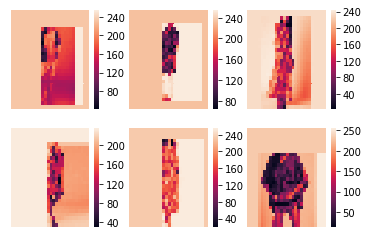

In [13]:
show_instances("features")

In [14]:
# Clear the dataset in the case you ran this cell before.
dataset_train = dataset_train.select("features", "label", "label_encoded")
dataset_test = dataset_test.select("features", "label", "label_encoded")
# Normalize the features between Min:0-Max:1
transformer = MinMaxTransformer(n_min=0.0, n_max=1.0, \
                                o_min=0.0, o_max=255.0, \
                                input_col="features", \
                                output_col="features_normalized")
dataset_train = transformer.transform(dataset_train)
dataset_test = transformer.transform(dataset_test)

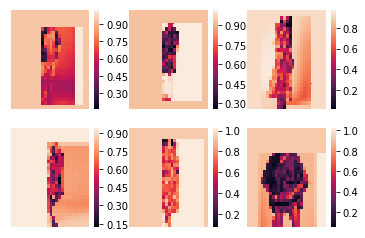

In [15]:
show_instances("features_normalized")

In [ ]:
mlp = Sequential()
mlp.add(Dense(1000, input_shape=(784,)))
mlp.add(Activation('relu'))
mlp.add(Dense(250))
mlp.add(Activation('relu'))
mlp.add(Dense(nb_classes))
mlp.add(Activation('softmax'))

In [17]:
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              785000    
_________________________________________________________________
activation_1 (Activation)    (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               250250    
_________________________________________________________________
activation_2 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 46)                11546     
_________________________________________________________________
activation_3 (Activation)    (None, 46)                0         
Total params: 1,046,796
Trainable params: 1,046,796
Non-trainable params: 0
_________________________________________________________________


In [16]:
optimizer = 'adam'
loss = 'categorical_crossentropy'

In [17]:
# Used only for Conv model
reshape_transformer = ReshapeTransformer("features_normalized", "matrix", (28, 28, 1))
dataset_train = reshape_transformer.transform(dataset_train)
dataset_test = reshape_transformer.transform(dataset_test)

In [18]:
dataset_train.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: long (nullable = true)
 |-- label_encoded: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- features_normalized: vector (nullable = true)
 |-- matrix: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: double (containsNull = true)



In [19]:
dataset_train = dataset_train.select("matrix", "label", "label_encoded")
dataset_test = dataset_test.select("matrix", "label", "label_encoded")

In [22]:
dense_transformer = DenseTransformer(input_col="features_normalized", output_col="features_normalized_dense")
dataset_train = dense_transformer.transform(dataset_train)
dataset_test = dense_transformer.transform(dataset_test)
dataset_train.repartition(num_workers)
dataset_test.repartition(num_workers)

DataFrame[features_normalized: vector, label: bigint, label_encoded: array<double>, features_normalized_dense: vector]

In [20]:
# Partitioning the training and test set.
training_set = dataset_train.repartition(num_workers)
test_set = dataset_test.repartition(num_workers)

### Training MLP 

In [24]:
trainer = DOWNPOUR(keras_model=mlp, worker_optimizer=optimizer, loss=loss, num_workers=num_workers,
                   batch_size=4, communication_window=5, num_epoch=1,
                   features_col="features_normalized_dense", label_col="label_encoded")
trained_model = trainer.train(training_set)

In [25]:
print("Training time: " + str(trainer.get_training_time()))
print("Accuracy: " + str(evaluate_accuracy(trained_model, test_set)))

Training time: 2929.81969404
Accuracy: 0.127275


In [26]:
trainer.parameter_server.num_updates

10458

In [24]:
trainer = ADAG(keras_model=mlp, worker_optimizer=optimizer, loss=loss, num_workers=num_workers,
               batch_size=4, communication_window=15, num_epoch=1,
               features_col="features_normalized_dense", label_col="label_encoded")
trained_model = trainer.train(training_set)

In [25]:
print("Training time: " + str(trainer.get_training_time()))
print("Accuracy: " + str(evaluate_accuracy(trained_model, test_set)))

Training time: 1707.23561287
Accuracy: 0.094725


In [26]:
trainer.parameter_server.num_updates

3487

In [27]:
trainer = AEASGD(keras_model=mlp, worker_optimizer=optimizer, loss=loss, num_workers=num_workers,
                 batch_size=4, communication_window=35, num_epoch=1, features_col="features_normalized_dense",
                 label_col="label_encoded")
trained_model = trainer.train(training_set)

In [28]:
print("Training time: " + str(trainer.get_training_time()))
print("Accuracy: " + str(evaluate_accuracy(trained_model, test_set)))

Training time: 1635.60763383
Accuracy: 0.06925


In [29]:
trainer.parameter_server.num_updates

1495

In [34]:
trainer = SingleTrainer(keras_model=mlp, worker_optimizer=optimizer, loss=loss,
                        batch_size=16, num_epoch=1, features_col="features_normalized_dense",
                 label_col="label_encoded")
trained_model = trainer.train(training_set)

In [35]:
print("Training time: " + str(trainer.get_training_time()))
print("Accuracy: " + str(evaluate_accuracy(trained_model, test_set)))

Training time: 2.28733611107
Accuracy: 0.127275


### After re-reading and re-preprocessing the data, Training ConvNet

In [21]:
conv = Sequential()
conv.add(Conv2D(32, kernel_size=3, strides=1, input_shape=(28, 28, 1)))
conv.add(Activation('relu'))
conv.add(MaxPooling2D(2))
conv.add(Conv2D(64, kernel_size=3, strides=1))
conv.add(Activation('relu'))
conv.add(MaxPooling2D(2))
conv.add(Flatten())
conv.add(Dense(256))
conv.add(Activation('relu'))
conv.add(Dense(46))
conv.add(Activation('softmax'))

In [22]:
conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
__________

In [23]:
trainer = DOWNPOUR(keras_model=conv, worker_optimizer=optimizer, loss=loss, num_workers=num_workers,
                   batch_size=4, communication_window=5, num_epoch=1,
                   features_col="matrix", label_col="label_encoded")
trained_model = trainer.train(training_set)

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/py4j/java_gateway.py", line 985, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python2.7/dist-packages/py4j/java_gateway.py", line 1164, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
Py4JNetworkError: Error while receiving
Exception KeyboardInterrupt: KeyboardInterrupt() in <function <lambda> at 0x7f2691d4f5f0> ignored
Exception KeyboardInterrupt: KeyboardInterrupt() in <function <lambda> at 0x7f2673c2ff50> ignored


Py4JError: An error occurred while calling o26.setCallSite

In [ ]:
print("Training time: " + str(trainer.get_training_time()))
print("Accuracy: " + str(evaluate_accuracy(trained_model, test_set, features="matrix")))

In [ ]:
trainer.parameter_server.num_updates

In [ ]:
trainer = ADAG(keras_model=conv, worker_optimizer=optimizer, loss=loss, num_workers=num_workers,
               batch_size=4, communication_window=15, num_epoch=1,
               features_col="matrix", label_col="label_encoded")
trained_model = trainer.train(training_set)

In [ ]:
print("Training time: " + str(trainer.get_training_time()))
print("Accuracy: " + str(evaluate_accuracy(trained_model, test_set, features="matrix")))

In [ ]:
trainer.parameter_server.num_updates

In [ ]:
trainer = AEASGD(keras_model=conv, worker_optimizer=optimizer, loss=loss, num_workers=num_workers,
                 batch_size=4, communication_window=25, num_epoch=1, features_col="matrix",
                 label_col="label_encoded")
trained_model = trainer.train(training_set)

In [ ]:
print("Training time: " + str(trainer.get_training_time()))
print("Accuracy: " + str(evaluate_accuracy(trained_model, test_set, features="matrix")))

In [ ]:
trainer.parameter_server.num_updates

In [28]:
trainer = SingleTrainer(keras_model=conv, worker_optimizer=optimizer, loss=loss,
                        batch_size=4, num_epoch=1, features_col="matrix",
                 label_col="label_encoded")
trained_model = trainer.train(training_set)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 5 in stage 46.0 failed 1 times, most recent failure: Lost task 5.0 in stage 46.0 (TID 137, localhost, executor driver): org.apache.spark.memory.SparkOutOfMemoryError: error while calling spill() on org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter@46f1d9fd : No space left on device
	at org.apache.spark.memory.TaskMemoryManager.acquireExecutionMemory(TaskMemoryManager.java:219)
	at org.apache.spark.memory.TaskMemoryManager.allocatePage(TaskMemoryManager.java:285)
	at org.apache.spark.memory.MemoryConsumer.allocatePage(MemoryConsumer.java:117)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.acquireNewPageIfNecessary(UnsafeExternalSorter.java:383)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.insertRecord(UnsafeExternalSorter.java:407)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.insertRow(UnsafeExternalRowSorter.java:135)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.sort(UnsafeExternalRowSorter.java:217)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$anonfun$2.apply(ShuffleExchangeExec.scala:295)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$anonfun$2.apply(ShuffleExchangeExec.scala:266)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.memory.SparkOutOfMemoryError: error while calling spill() on org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter@46f1d9fd : No space left on device
	at org.apache.spark.memory.TaskMemoryManager.acquireExecutionMemory(TaskMemoryManager.java:219)
	at org.apache.spark.memory.TaskMemoryManager.allocatePage(TaskMemoryManager.java:285)
	at org.apache.spark.memory.MemoryConsumer.allocatePage(MemoryConsumer.java:117)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.acquireNewPageIfNecessary(UnsafeExternalSorter.java:383)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.insertRecord(UnsafeExternalSorter.java:407)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.insertRow(UnsafeExternalRowSorter.java:135)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.sort(UnsafeExternalRowSorter.java:217)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$anonfun$2.apply(ShuffleExchangeExec.scala:295)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$anonfun$2.apply(ShuffleExchangeExec.scala:266)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [ ]:
print("Training time: " + str(trainer.get_training_time()))
print("Accuracy: " + str(evaluate_accuracy(trained_model, test_set, features="matrix")))